In [181]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 0: Data Preparation & EDA

### Import WikiVote Dataset

In [182]:
import re

header_info = {}
df_start_line = 0

with open("dataset/wiki-Vote.txt", "rt") as f:
    for i, line in enumerate(f):
        if not line.startswith("#"):
            df_start_line = i
            break

        if "Nodes:" in line and "Edges:" in line:
            match = re.search(r"Nodes:\s*(\d+)\s*Edges:\s*(\d+)", line)
            if match:
                header_info["nodes"] = int(match.group(1))
                header_info["edges"] = int(match.group(2))

In [183]:
edges_wv = pd.read_csv("dataset/wiki-Vote.txt.gz", sep="\t", header=None, names=["src", "dst"], skiprows=df_start_line)
edges_wv.head()

,src,dst
0,30,1412
1,30,3352
2,30,5254
3,30,5543
4,30,7478


## 0-1: Checking Nodes & Edges

In [184]:
num_nodes_wv = int(max(edges_wv["src"].max(), edges_wv["dst"].max()) + 1)
num_edges_wv = len(edges_wv)

print(f"Number of nodes: {num_nodes_wv}")
print(f"Number of edges: {num_edges_wv}")

Number of nodes: 8298
Number of edges: 103689


## 0-2: in-degree & out-degree calculation

In [185]:
out_degree_wv = np.zeros(num_nodes_wv, dtype=np.int64)
in_degree_wv = np.zeros(num_nodes_wv, dtype=np.int64)

for u, v in edges_wv.itertuples(index=False):
    out_degree_wv[u] += 1
    in_degree_wv[v] += 1


in_stats = {"max": int(np.max(in_degree_wv)), "mean": float(np.mean(in_degree_wv)), "median": float(np.median(in_degree_wv)),
            "zero_percent": float(np.sum(in_degree_wv == 0) / len(in_degree_wv) * 100)}

out_stats = {"max": int(np.max(out_degree_wv)), "mean": float(np.mean(out_degree_wv)), "median": float(np.median(out_degree_wv)),
             "zero_percent": float(np.sum(out_degree_wv == 0) / len(out_degree_wv) * 100)}

summary_df = pd.DataFrame.from_dict({"In-degree": in_stats, "Out-degree": out_stats}, orient="index")
summary_df

,max,mean,median,zero_percent
In-degree,457,12.495662,0.0,71.306339
Out-degree,893,12.495662,1.0,26.367799


## 0-3: Checking Self Loops

In [186]:
num_self_loops_wv = (edges_wv["src"] == edges_wv["dst"]).sum()
print(f"Number of self-loops: {num_self_loops_wv}")

Number of self-loops: 0


## dangling nodes (out-degree = 0)

In [187]:
dangling_nodes_wv = np.sum(out_degree_wv == 0)
dangling_percent_wv = dangling_nodes_wv / num_nodes_wv * 100

print(f"Dangling nodes: {dangling_nodes_wv}")
print(f"Dangling percent: {dangling_percent_wv} %")

Dangling nodes: 2188
Dangling percent: 26.367799469751745 %


## 0-4: Nodes based on Top-20

### Top-20 for in-degree

In [188]:
def top_k_nodes(deg, k=20):
    idx = np.argsort(-deg)
    top_list = list(zip(idx[:k], deg[idx[:k]]))

    top_return_list = []
    for node, d in top_list:
        top_return_list.append({'Node':node, 'Degree': d})
    return top_return_list


top20_in_df = pd.DataFrame(top_k_nodes(in_degree_wv, 20))
top20_in_df

,Node,Degree
0,4037,457
1,15,361
2,2398,340
3,2625,331
4,1297,309
5,2565,274
6,762,272
7,2328,266
8,5254,265
9,3352,264


### Top-20 for out-degree

In [189]:
top20_out_df = pd.DataFrame(top_k_nodes(out_degree_wv, 20))
top20_out_df

,Node,Degree
0,2565,893
1,766,773
2,11,743
3,457,732
4,2688,618
5,1166,599
6,1549,587
7,1151,472
8,1374,462
9,1133,399


## 0-5: Rank-Degree(log-log) plot

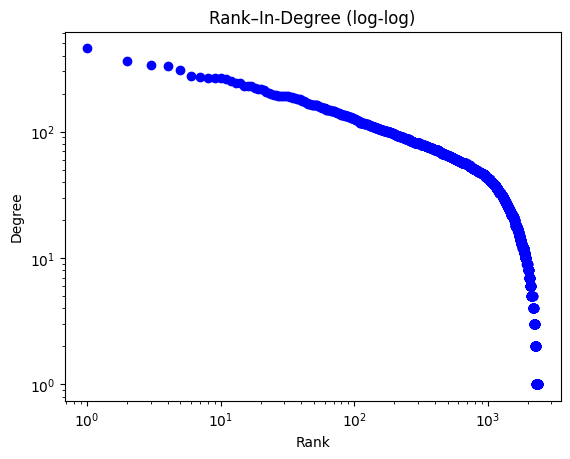

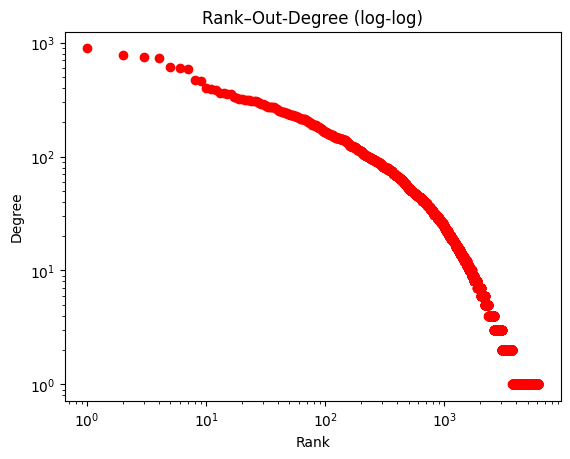

In [190]:
def plot_rank_degree(deg, title, color):
    sorted_deg = np.sort(deg)[::-1]
    ranks = np.arange(1, len(sorted_deg) + 1)

    mask = sorted_deg > 0
    plt.figure()
    plt.loglog(ranks[mask], sorted_deg[mask], marker='o', linestyle='None', color=color)
    plt.xlabel("Rank")
    plt.ylabel("Degree")
    plt.title(title)
    plt.show()

plot_rank_degree(in_degree_wv, "Rank–In-Degree (log-log)", 'blue')
plot_rank_degree(out_degree_wv, "Rank–Out-Degree (log-log)", 'red')

# Step 1: Dense PageRank on WikiVote Subgraphs

## 1-1: Load nodes & edges + Preprocessing of A & B

### Loading A Subgraph Data

In [191]:
EDGES_PATH = "dataset/wikivote_subgraph_A_edges.tsv"

edges_A = pd.read_csv(EDGES_PATH, sep="\t")
edges_A.head()

,src,dst
0,0,3
1,0,13
2,0,30
3,0,53
4,0,118


In [192]:
num_edges_A = len(edges_A)
num_nodes_A = int(max(edges_A["src"].max(), edges_A["dst"].max()) + 1)

In [193]:
out_degree_A = np.zeros(num_nodes_A, dtype=np.int64)
in_degree_A = np.zeros(num_nodes_A, dtype=np.int64)

for u, v in edges_A.itertuples(index=False):
    out_degree_A[u] += 1
    in_degree_A[v] += 1


in_stats = {"max": int(np.max(in_degree_A)), "mean": float(np.mean(in_degree_A)), "median": float(np.median(in_degree_A)),
            "zero_percent": float(np.sum(in_degree_A == 0) / len(in_degree_A) * 100)}

out_stats = {"max": int(np.max(out_degree_A)), "mean": float(np.mean(out_degree_A)), "median": float(np.median(out_degree_A)),
             "zero_percent": float(np.sum(out_degree_A == 0) / len(out_degree_A) * 100)}

summary_df = pd.DataFrame.from_dict({"In-degree": in_stats, "Out-degree": out_stats}, orient="index")
summary_df

,max,mean,median,zero_percent
In-degree,95,25.382,22.0,0.0
Out-degree,499,25.382,7.0,25.6


In [194]:
num_self_loops_A = (edges_A["src"] == edges_A["dst"]).sum()
dangling_nodes_A = np.sum(out_degree_A == 0)
dangling_percent_A = dangling_nodes_A / num_nodes_A * 100

### Loading B Subgraph Data

In [195]:
EDGES_PATH_B = "dataset/wikivote_subgraph_B_edges.tsv"

edges_B = pd.read_csv(EDGES_PATH_B, sep="\t")
edges_B.head()

,src,dst
0,11,0
1,11,1
2,11,9
3,11,14
4,11,15


In [196]:
num_edges_B = len(edges_B)
num_nodes_B = int(max(edges_B["src"].max(), edges_B["dst"].max()) + 1)

In [197]:
out_degree_B = np.zeros(num_nodes_B, dtype=np.int64)
in_degree_B = np.zeros(num_nodes_B, dtype=np.int64)

for u, v in edges_B.itertuples(index=False):
    out_degree_B[u] += 1
    in_degree_B[v] += 1


in_stats_B = {"max": int(np.max(in_degree_B)), "mean": float(np.mean(in_degree_B)), "median": float(np.median(in_degree_B)),
              "zero_percent": float(np.sum(in_degree_B == 0) / len(in_degree_B) * 100)}

out_stats_B = {"max": int(np.max(out_degree_B)), "mean": float(np.mean(out_degree_B)), "median": float(np.median(out_degree_B)),
               "zero_percent": float(np.sum(out_degree_B == 0) / len(out_degree_B) * 100)}

summary_df_B = pd.DataFrame.from_dict({"In-degree": in_stats_B, "Out-degree": out_stats_B}, orient="index")
summary_df_B

,max,mean,median,zero_percent
In-degree,169,29.902,27.5,36.0
Out-degree,178,29.902,23.0,0.0


In [198]:
dangling_nodes_B = np.sum(out_degree_B == 0)
dangling_percent_B = dangling_nodes_B / num_nodes_B * 100
num_self_loops_B = (edges_B["src"] == edges_B["dst"]).sum()

### subgraph Report

In [199]:
report_list = [{'Subgraph': 'A', 'Nodes': num_nodes_A, 'Edges': num_edges_A, 'Self_Loops': num_self_loops_A, 'Deadends': dangling_nodes_A, 'Deadend_percent': dangling_percent_A},
               {'Subgraph': 'B', 'Nodes': num_nodes_B, 'Edges': num_edges_B, 'Self_Loops': num_self_loops_B, 'Deadends': dangling_nodes_B, 'Deadend_percent': dangling_percent_B}]

report_list = pd.DataFrame(report_list)
report_list

,Subgraph,Nodes,Edges,Self_Loops,Deadends,Deadend_percent
0,A,500,12691,0,128,25.6
1,B,500,14951,0,0,0.0


## 1-2: Build Adjacency Matrix

In [200]:
n_A = int(max(edges_A["src"].max(), edges_A["dst"].max()) + 1)
m_A = len(edges_A)

A = np.zeros((n_A, n_A), dtype=np.float64)
for u, v in edges_A.itertuples(index=False):
    A[u, v] = 1.0


n_B = int(max(edges_B["src"].max(), edges_B["dst"].max()) + 1)
m_B = len(edges_B)

B = np.zeros((n_B, n_B), dtype=np.float64)
for u, v in edges_B.itertuples(index=False):
    B[u, v] = 1.0

## 1-3: Build Transition Matrix

In [201]:
out_degree_A = A.sum(axis=1)
out_degree_B = B.sum(axis=1)


num_deadends_A = np.sum(out_degree_A == 0)
num_deadends_B = np.sum(out_degree_B == 0)

In [202]:
P_A = np.zeros_like(A)

for i in range(n_A):
    if out_degree_A[i] > 0:
        P_A[i, :] = A[i, :] / out_degree_A[i]


P_B = np.zeros_like(B)

for i in range(n_B):
    if out_degree_B[i] > 0:
        P_B[i, :] = B[i, :] / out_degree_B[i]

In [203]:
P_A[:10, :10]

array([[0.        , 0.        , 0.        , 0.16666667, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.33333333, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.5       , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.03448276, 0.03448276, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.01666667, 0.        ,
        0.01666667, 0.        , 0.01666667, 0.01666667, 0.        ],
       [0.        , 0.        , 0.       

In [204]:
P_B[:10, :10]

array([[0.        , 0.01724138, 0.        , 0.01724138, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01724138],
       [0.04      , 0.        , 0.        , 0.04      , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.04      ],
       [0.        , 0.08333333, 0.        , 0.08333333, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.08333333],
       [0.06666667, 0.06666667, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.06666667],
       [0.00699301, 0.00699301, 0.        , 0.00699301, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00699301],
       [0.        , 0.07142857, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.05882353, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.05882353],
       [0.025     , 0.        , 0.       

## 1-4: Basic PageRank (without deadend fix)
#### calculate the stationary distribution using Power Method

In [205]:
MAX_ITER = 500
eps = 1e-9
r = 0.15


def basic_pageRank(transition_matrix: np.ndarray, nodes: int, eps=1e-9, r=0.15, max_iteration=10_000):

    p = np.ones(nodes) / nodes
    teleport = np.ones(nodes) / nodes

    residuals = []
    for _ in range(max_iteration):
        p_next = (1 - r) * (transition_matrix.T @ p) + (r * teleport)
        residual = np.linalg.norm(p_next - p, 1)

        residuals.append(residual)
        p = p_next

        if residual < eps:
            return p, residuals


p_A_basic, residuals_basic_A = basic_pageRank(transition_matrix=P_A, nodes=n_A, eps=eps, r=r, max_iteration=MAX_ITER)
p_B_basic, residuals_basic_B = basic_pageRank(transition_matrix=P_B, nodes=n_B, eps=eps, r=r, max_iteration=MAX_ITER)

### Execution Report for Basic PageRank

In [206]:
pagerank_basic_report_df = [{'subgraph': 'A', 'iterations': len(residuals_basic_A), 'pagerank_value_sum': sum(p_A_basic), 'last_residual': residuals_basic_A[-1]},
                            {'subgraph': 'B', 'iterations': len(residuals_basic_B), 'pagerank_value_sum': sum(p_B_basic),'last_residual': residuals_basic_B[-1]}]

pagerank_basic_report_df = pd.DataFrame(pagerank_basic_report_df)
pagerank_basic_report_df

,subgraph,iterations,pagerank_value_sum,last_residual
0,A,49,0.435101,7.511420e-10
1,B,41,1.000000,6.293527e-10


In [207]:
top10_A = np.argsort(-p_A_basic)[:10]

top10_table_basic_page_rank_A = []
for rank, node in enumerate(top10_A, 1):
    top10_table_basic_page_rank_A.append({'Rank': rank, 'Node': node, 'Score': p_A_basic[node]})

top10_table_basic_page_rank_A = pd.DataFrame(top10_table_basic_page_rank_A)
top10_table_basic_page_rank_A

,Rank,Node,Score
0,1,168,0.003736
1,2,88,0.003162
2,3,132,0.003141
3,4,322,0.003017
4,5,338,0.002998
5,6,121,0.002748
6,7,448,0.002704
7,8,468,0.002619
8,9,426,0.002438
9,10,498,0.002422


In [208]:
top10_B = np.argsort(-p_B_basic)[:10]

top10_table_basic_page_rank_B = []
for rank, node in enumerate(top10_B, 1):
    top10_table_basic_page_rank_B.append({'Rank': rank, 'Node': node, 'Score': p_B[node]})

top10_table_basic_page_rank_B = pd.DataFrame(top10_table_basic_page_rank_B)
top10_table_basic_page_rank_B

,Rank,Node,Score
0,1,250,0.012321
1,2,265,0.011402
2,3,181,0.010663
3,4,318,0.010038
4,5,448,0.009008
5,6,336,0.008834
6,7,157,0.008833
7,8,242,0.008756
8,9,333,0.008525
9,10,92,0.008515


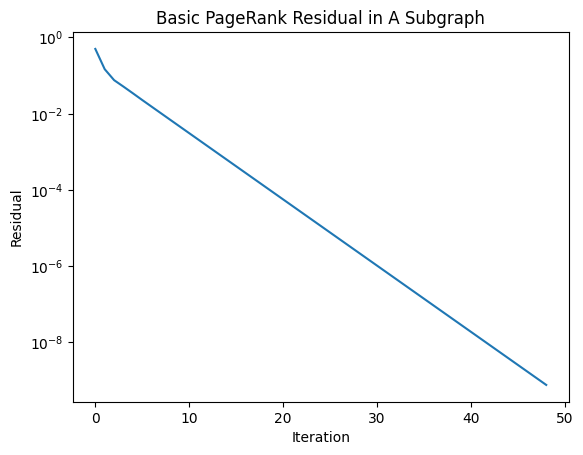

In [209]:
plt.figure()
plt.semilogy(residuals_basic_A)
plt.xlabel("Iteration")
plt.ylabel("Residual")
plt.title("Basic PageRank Residual in A Subgraph")
plt.show()

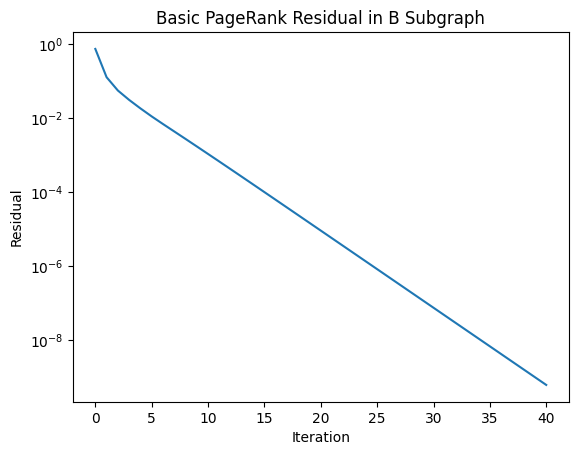

In [210]:
plt.figure()
plt.semilogy(residuals_basic_B)
plt.xlabel("Iteration")
plt.ylabel("Residual")
plt.title("Basic PageRank Residual in B Subgraph")
plt.show()

## 1-5: PageRank (with deadend handling)
#### calculate the stationary distribution using Power Method

In [211]:
MAX_ITER = 500
eps = 1e-9
r = 0.15

def pagerank_deadend_fix(transition_matrix: np.ndarray, out_degree: np.ndarray, nodes: int, eps=1e-9, r=0.15, max_iteration=500):

    p = np.ones(nodes) / nodes
    teleport = np.ones(nodes) / nodes

    deadend_mask = (out_degree == 0)

    residuals = []
    for _ in range(max_iteration):
        leaked_mass = p[deadend_mask].sum()
        p_next = ((1 - r) * (transition_matrix.T @ p)) + ((1 - r) * (leaked_mass * teleport)) + (r * teleport)
        residual = np.linalg.norm(p_next - p, 1)

        residuals.append(residual)
        p = p_next

        if residual < eps:
            return p, residuals


p_A, residuals_A = pagerank_deadend_fix(transition_matrix=P_A, out_degree=out_degree_A, nodes=n_A, eps=eps, r=r, max_iteration=MAX_ITER)
p_B, residuals_B = pagerank_deadend_fix(transition_matrix=P_B, out_degree=out_degree_B, nodes=n_B, eps=eps, r=r, max_iteration=MAX_ITER)

In [212]:
print("residual_last for A:", residuals_A[-1])
print("Sum of PageRank values A:", p_A.sum())
print("Iteration on A:", len(residuals_A))

print("\nresidual_last for B:", residuals_B[-1])
print("Sum of PageRank values B:", p_B.sum())
print("Iteration on B:", len(residuals_B))

residual_last for A: 4.1766603814819697e-10
Sum of PageRank values A: 0.9999999999999997
Iteration on A: 18

residual_last for B: 6.293526556020237e-10
Sum of PageRank values B: 0.9999999999999996
Iteration on B: 41


In [213]:
top10_A = np.argsort(-p_A)[:10]

top10_table_basic_page_rank_A = []
for rank, node in enumerate(top10_A, 1):
    top10_table_basic_page_rank_A.append({'Rank': rank, 'Node': node, 'Score': p_A[node]})

top10_table_basic_page_rank_A = pd.DataFrame(top10_table_basic_page_rank_A)
top10_table_basic_page_rank_A

,Rank,Node,Score
0,1,168,0.008587
1,2,88,0.007267
2,3,132,0.007218
3,4,322,0.006935
4,5,338,0.006891
5,6,121,0.006315
6,7,448,0.006216
7,8,468,0.006019
8,9,426,0.005602
9,10,498,0.005566


In [214]:
top10_B = np.argsort(-p_B)[:10]

top10_table_basic_page_rank_B = []
for rank, node in enumerate(top10_B, 1):
    top10_table_basic_page_rank_B.append({'Rank': rank, 'Node': node, 'Score': p_B[node]})

top10_table_basic_page_rank_B = pd.DataFrame(top10_table_basic_page_rank_B)
top10_table_basic_page_rank_B

,Rank,Node,Score
0,1,250,0.012321
1,2,265,0.011402
2,3,181,0.010663
3,4,318,0.010038
4,5,448,0.009008
5,6,336,0.008834
6,7,157,0.008833
7,8,242,0.008756
8,9,333,0.008525
9,10,92,0.008515


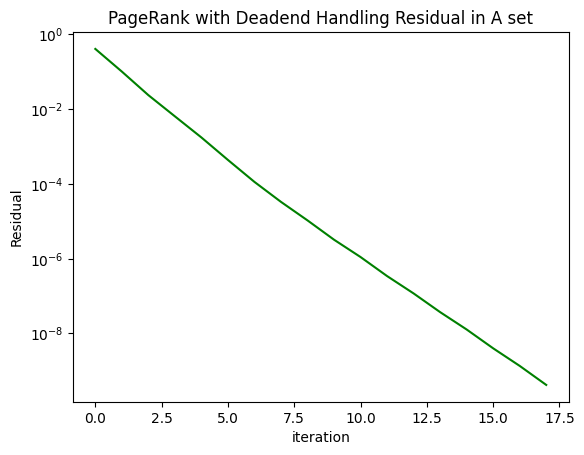

In [215]:
plt.figure()
plt.semilogy(residuals_A, color='green')
plt.xlabel("iteration")
plt.ylabel("Residual")
plt.title("PageRank with Deadend Handling Residual in A set")
plt.show()

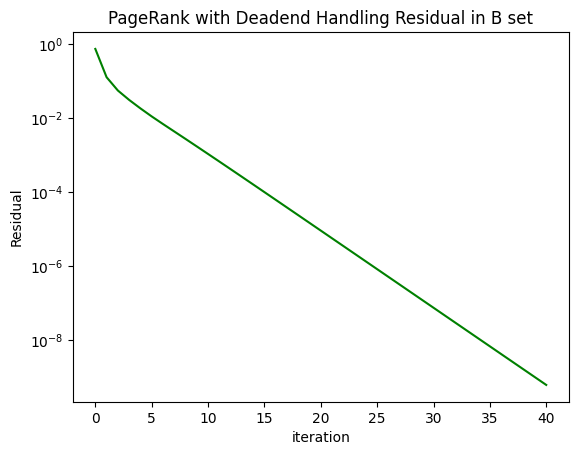

In [216]:
plt.figure()
plt.semilogy(residuals_B, color='green')
plt.xlabel("iteration")
plt.ylabel("Residual")
plt.title("PageRank with Deadend Handling Residual in B set")
plt.show()

# Step 2: Sparse PageRank (CSR)

## 2-0: Build CSR adjacency matrix

In [217]:
from scipy.sparse import csr_matrix

data_A = np.ones(m_A, dtype=np.float64)
rows_A = edges_A["src"].to_numpy()
cols_A = edges_A["dst"].to_numpy()

t0 = time.time()
A_csr = csr_matrix((data_A, (rows_A, cols_A)), shape=(n_A, n_A))
t_build_A = time.time() - t0


data_B = np.ones(m_B, dtype=np.float64)
rows_B = edges_B["src"].to_numpy()
cols_B = edges_B["dst"].to_numpy()

t0 = time.time()
B_csr = csr_matrix((data_B, (rows_B, cols_B)), shape=(n_B, n_B))
t_build_B = time.time() - t0


nnz_A = A_csr.nnz
nnz_B = B_csr.nnz

report_df = [{'Dataset': 'A', 'Nodes': n_A, 'Edges': m_A, 'NNZ': nnz_A, 'Build_Time': t_build_A},
             {'Dataset': 'B', 'Nodes': n_B, 'Edges': m_B, 'NNZ': nnz_B, 'Build_Time': t_build_B}]

report_df = pd.DataFrame(report_df)
report_df

,Dataset,Nodes,Edges,NNZ,Build_Time
0,A,500,12691,12691,0.000000
1,B,500,14951,14951,0.000997


## 2-1: Row-normalization (Transition matrix P)

In [218]:
out_degree_A = np.array(A_csr.sum(axis=1)).flatten()
out_degree_B = np.array(B_csr.sum(axis=1)).flatten()

def row_normalization(shape: int, csr: np.ndarray, out_degree: np.ndarray):
    t0 = time.time()

    inv_out = np.zeros_like(out_degree)
    mask = out_degree > 0
    inv_out[mask] = 1.0 / out_degree[mask]

    D_inv = csr_matrix((inv_out, (np.arange(shape), np.arange(shape))), shape=(shape, shape))
    P = D_inv @ csr
    t_norm = time.time() - t0

    return P, t_norm

P_A, normalization_time_A = row_normalization(shape=n_A, csr=A_csr, out_degree=out_degree_A)
P_B, normalization_time_B = row_normalization(shape=n_B, csr=B_csr, out_degree=out_degree_B)

In [219]:
deadends_A = np.sum(out_degree_A == 0)
deadends_B = np.sum(out_degree_B == 0)

print('Deadends for A_csr', deadends_A)
print('Deadends for B_csr', deadends_B)

Deadends for A_csr 128
Deadends for B_csr 0


In [220]:
print('Normalization time for A_csr', normalization_time_A)
print('Normalization time for B_csr', normalization_time_B)

Normalization time for A_csr 0.0
Normalization time for B_csr 0.0


## 2-2: Sparse PageRank (Power Iteration)

In [221]:
def pagerank_sparse(transition_matrix: np.ndarray, number_nodes: int, eps=1e-9, r=0.15, max_iteration=500):

    p = np.ones(number_nodes) / number_nodes
    teleport = np.ones(number_nodes) / number_nodes

    residuals = []
    t0 = time.time()

    for it in range(max_iteration):
        p_next = ((1 - r) * (transition_matrix.T @ p)) + (r * teleport)
        residual = np.linalg.norm(p_next - p, 1)
        residuals.append(residual)
        p = p_next

        if residual < eps:
            page_time = time.time() - t0
            return p, residuals, page_time

p_A, residuals_A, page_time_A = pagerank_sparse(transition_matrix=P_A, number_nodes=n_A)
p_B, residuals_B, page_time_B = pagerank_sparse(transition_matrix=P_B, number_nodes=n_B)

### Execution Report

In [222]:
pagerank_sparce_report_df = [{'dataset': 'A', 'iterations': len(residuals_A), 'last_residual': residuals_A[-1], 'sum_pagerank_values': p_A.sum(), 'converge_time': page_time_A,
                              'total_time': (t_build_A + normalization_time_A + page_time_A)},
                             {'dataset': 'B', 'iterations': len(residuals_B), 'last_residual': residuals_B[-1], 'sum_pagerank_values': p_B.sum(), 'converge_time': page_time_B,
                              'total_time': (t_build_B + normalization_time_B + page_time_B)},]

pagerank_sparce_report_df = pd.DataFrame(pagerank_sparce_report_df)
pagerank_sparce_report_df

,dataset,iterations,last_residual,sum_pagerank_values,converge_time,total_time
0,A,49,7.511420e-10,0.435101,0.00251,0.002510
1,B,41,6.293526e-10,1.000000,0.00200,0.002996


## 2-3: Sparse PageRank & Full Graph

### import Full Graph

In [223]:
import re

header_info = {}
df_start_line = 0

with open("dataset/wiki-Vote.txt", "rt") as f:
    for i, line in enumerate(f):
        if not line.startswith("#"):
            df_start_line = i
            break

        if "Nodes:" in line and "Edges:" in line:
            match = re.search(r"Nodes:\s*(\d+)\s*Edges:\s*(\d+)", line)
            if match:
                header_info["nodes"] = int(match.group(1))
                header_info["edges"] = int(match.group(2))

print('header: ', header_info)
print('start line:', df_start_line)

header:  {'nodes': 7115, 'edges': 103689}
start line: 4


In [224]:
edges = pd.read_csv("dataset/wiki-Vote.txt.gz", sep="\t", header=None, names=["src", "dst"], skiprows=df_start_line)
edges.head()

,src,dst
0,30,1412
1,30,3352
2,30,5254
3,30,5543
4,30,7478


### Build CSR for Full Graph

In [225]:
n_full = header_info['nodes']
m_full = header_info['edges']


data_full_graph = np.ones(m_A, dtype=np.float64)
rows_full = edges_A["src"].to_numpy()
cols_full = edges_A["dst"].to_numpy()

t0 = time.time()
full_graph_csr = csr_matrix((data_full_graph, (rows_full, cols_full)), shape=(n_full, n_full))
t_build_full = time.time() - t0


nnz_full_graph = full_graph_csr.nnz

report_df = [{'Dataset': 'Full Graph', 'Nodes': n_full, 'Edges': m_full, 'NNZ': nnz_full_graph, 'Build_Time': t_build_full}]
report_df = pd.DataFrame(report_df)
report_df

,Dataset,Nodes,Edges,NNZ,Build_Time
0,Full Graph,7115,103689,12691,0.0


### app Sparse PageRank on Full Graph

In [226]:
out_degree_full = np.array(full_graph_csr.sum(axis=1)).flatten()
transition_matrix_full_graph, normalization_time_full = row_normalization(shape=n_full, csr=full_graph_csr, out_degree=out_degree_full)
p_full, residuals_full, page_time_full = pagerank_sparse(transition_matrix=transition_matrix_full_graph, number_nodes=n_full)

### Execution Report

In [227]:
pagerank_sparce_report_df = [{'dataset': 'Full Graph', 'iterations': len(residuals_full), 'last_residual': residuals_full[-1], 'sum_pagerank_values': p_full.sum(), 'converge_time': page_time_full,
                              'total_time': (t_build_full + normalization_time_full + page_time_full)}]

pagerank_sparce_report_df = pd.DataFrame(pagerank_sparce_report_df)
pagerank_sparce_report_df

,dataset,iterations,last_residual,sum_pagerank_values,converge_time,total_time
0,Full Graph,42,8.708277e-10,0.170035,0.003585,0.003585


# Step 3: Personalized PageRank + deadend/dummy

## 3-A-1: PageRank with Deadend Fix – q-fix

In [228]:
def pagerank_q_fix(transition_matrix: np.ndarray, q, deadend_mask, eps=1e-9, r=0.15, max_iteration=500):
    p = q.copy()
    residuals = []

    t0 = time.time()
    for it in range(max_iteration):
        leaked_mass = p[deadend_mask].sum()

        p_next = ((1 - r) * (transition_matrix.T @ p)
                  + (1 - r) * leaked_mass * q
                  + r * q)


        residual = np.linalg.norm(p_next - p, 1)
        residuals.append(residual)
        p = p_next

        if residual < eps:
            break

    pagerank_time = time.time() - t0
    return p, residuals, pagerank_time

In [229]:
seed = 0

q_full = np.zeros(n_full)
q_full[seed] = 1.0
q_full = q_full / q_full.sum()

deadend_mask_full = (out_degree_full == 0)

p_full_qfix, residuals_full_qfix, pagerank_time_full_qfix = pagerank_q_fix(transition_matrix=transition_matrix_full_graph, q=q_full,
                                                                           deadend_mask=deadend_mask_full, eps=1e-9, r=0.15, max_iteration=500)

### Top20 in pageRank with Q-Fix

In [230]:
top20_qfix = np.argsort(-p_full_qfix)[:20]
top20_qfix

array([  0, 171,  30,  13,  53, 118,   3,  88, 144, 420, 206, 168,  23,
        29, 121, 149, 285, 173, 132,   5], dtype=int64)

## 3-A-2: PageRank with Deadend Fix – u-fix

In [231]:
def pagerank_u_fix(transition_matrix: np.ndarray, u, deadend_mask, eps=1e-9, r=0.15, max_iteration=500):
    p = u.copy()
    residuals = []

    t0 = time.time()
    for _ in range(max_iteration):
        leaked_mass = p[deadend_mask].sum()

        p_next = ((1 - r) * (transition_matrix.T @ p) + (1 - r) * leaked_mass * u + r * u)

        residual = np.linalg.norm(p_next - p, 1)
        residuals.append(residual)
        p = p_next

        if residual < eps:
            break

    page_time = time.time() - t0
    return p, residuals, page_time

In [232]:
u_full = np.ones(n_full) / n_full
p_full_ufix, residuals_full_ufix, page_time_full_ufix = pagerank_u_fix(transition_matrix=transition_matrix_full_graph, u=u_full,
                                                                       deadend_mask=deadend_mask_full, eps=1e-9, r=0.15, max_iteration=500)

### Top20 in pageRank with U-Fix

In [233]:
top20_ufix = np.argsort(-p_full_ufix)[:20]
top20_ufix

array([168,  88, 132, 322, 338, 121, 448, 468, 426, 498,  35, 176, 149,
        13,  12, 285,  53, 359, 278, 331], dtype=int64)

### Execution report

In [234]:
pagerank_fix_report_df = [{'Methode': 'Q-Fix', 'dataset': 'Full Graph', 'iterations': len(residuals_full_qfix), 'last_residual': residuals_full_qfix[-1],
                              'sum_pagerank_values': p_full_qfix.sum(), 'converge_time': pagerank_time_full_qfix,
                              'total_time': (t_build_full + normalization_time_full + pagerank_time_full_qfix)},

                             {'Methode': 'U-Fix', 'dataset': 'Full Graph', 'iterations': len(residuals_full_ufix), 'last_residual': residuals_full_ufix[-1],
                              'sum_pagerank_values': p_full_ufix.sum(), 'converge_time': page_time_full_ufix,
                              'total_time': (t_build_full + normalization_time_full + page_time_full_ufix)}]

pagerank_fix_report_df = pd.DataFrame(pagerank_fix_report_df)
pagerank_fix_report_df

,Methode,dataset,iterations,last_residual,sum_pagerank_values,converge_time,total_time
0,Q-Fix,Full Graph,24,5.194719e-10,1.0,0.00200,0.00200
1,U-Fix,Full Graph,40,9.639756e-10,1.0,0.00351,0.00351


### Top20 intersection

In [235]:
intersection = np.intersect1d(top20_qfix, top20_ufix)
overlap_percentage = 100.0 * len(intersection) / 20

print('Overlap Percentage: ', overlap_percentage)
print(intersection)

Overlap Percentage:  40.0
[ 13  53  88 121 132 149 168 285]


## 3-B-1: Personalized PageRank on FullGraph

### Data preperation

In [236]:
seed_old_id = 4037

nodes = pd.Index(edges["src"]).union(edges["dst"])
id_map = {old_id: new_id for new_id, old_id in enumerate(nodes)}

new_edges_full = pd.DataFrame()
new_edges_full["src"] = edges["src"].map(id_map)
new_edges_full["dst"] = edges["dst"].map(id_map)


new_n_full = len(nodes)
new_m_full = len(edges)

In [237]:
new_edges_full

,src,dst
0,3403,44110
1,3403,94827
2,3403,133684
3,3403,138517
4,3403,164136
...,...,...
103684,170604,125844
103685,170605,125844
103686,169816,170618
103687,169816,170627


### personalized pagerank implementation

In [238]:
def personalized_pagerank(transition_matrix: np.ndarray, seed_idx: int, deadend_mask, eps=1e-9, r=0.15, max_iteration=10000):

    n = transition_matrix.shape[0]
    v = np.zeros(n)
    v[seed_idx] = 1.0

    p = v.copy()
    residuals = []

    t0 = time.time()
    for _ in range(max_iteration):

        leaked_mass = p[deadend_mask].sum()
        p_next = ((1 - r) * (transition_matrix.T @ p) + (1 - r) * leaked_mass * v + r * v)

        residual = np.linalg.norm(p_next - p, 1)
        residuals.append(residual)

        p = p_next
        if residual < eps:
            break

    page_time = time.time() - t0
    return p, residuals, page_time

p_ppr_full, residuals_ppr_full, page_time_ppr_full = personalized_pagerank(transition_matrix=transition_matrix_full_graph, seed_idx=seed_old_id,
                                                deadend_mask=deadend_mask_full, eps=1e-9, r=0.15, max_iteration=500)

### Execution Report

In [239]:
ppr_report_df = [{'Methode': 'personalized pagerank', 'dataset': 'Full Graph', 'iterations': len(residuals_ppr_full), 'last_residual': residuals_ppr_full[-1],
                           'sum_pagerank_values': p_ppr_full.sum(), 'converge_time': page_time_ppr_full}]

ppr_report_df = pd.DataFrame(ppr_report_df)
ppr_report_df

,Methode,dataset,iterations,last_residual,sum_pagerank_values,converge_time
0,personalized pagerank,Full Graph,1,0.0,1.0,0.000997


### Top20 (new id) with PPR

In [240]:
top20 = np.argsort(-p_ppr_full)[:20]
top20

array([4037,    0, 4749, 4748, 4747, 4746, 4745, 4744, 4743, 4742, 4741,
       4740, 4750, 4739, 4737, 4736, 4735, 4734, 4733, 4732], dtype=int64)